<a href="https://colab.research.google.com/github/zabirmohammad/LightArcNet/blob/main/Original_used_Lightweight_Activity_Regocnition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import shutil
import random
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import scipy.io

from scipy import stats
from statistics import mode
from tensorflow.keras import backend as K
# from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


import warnings
warnings.filterwarnings('ignore')

random.Random(12)
random.seed(12)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Wisdm 6 classes

In [ ]:
!cp -r /content/drive/MyDrive/Dataset/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt /content/WISDM_ar_v1.1_raw_error.txt

file_path = '/content/WISDM_ar_v1.1_raw_error.txt'
column_names = ['user','timesteps','Acc_x','Acc_y','Acc_z','Activity']

# Read the content of the file
with open(file_path, 'r') as file:
    file_content = file.read()

# Split the file content by '\n' to get rows
rows = file_content.split('\n')

# Initialize a new list to store the modified content
modified_rows = []

# Iterate through the rows
for row in rows:
    # Split each row by ',' to get timesteps
    double_line = row.split(';')

    for i in double_line:
      if i!='':
        timesteps = i.split(',')[:6]
        label = timesteps.pop(1)
        if timesteps[-1]=='': timesteps[-1]=4.4
        timesteps = [float(x) for x in timesteps]
        timesteps.append(label)

        modified_rows.append(timesteps)


df = pd.DataFrame(modified_rows,columns=column_names)
# Remove rows where 'timesteps' is 0
df = df[df['timesteps'] != 0]
df = df.drop(columns=['user','timesteps'])
df

,Acc_x,Acc_y,Acc_z,Activity
0,-0.694638,12.680544,0.503953,Jogging
1,5.012288,11.264028,0.953424,Jogging
2,4.903325,10.882658,-0.081722,Jogging
3,-0.612916,18.496431,3.023717,Jogging
4,-1.184970,12.108489,7.205164,Jogging
...,...,...,...,...
1098204,9.000000,-1.570000,1.690000,Sitting
1098205,9.040000,-1.460000,1.730000,Sitting
1098206,9.080000,-1.380000,1.690000,Sitting
1098207,9.000000,-1.460000,1.730000,Sitting


In [ ]:
window_size = 128
overlap_size = int(window_size * 0.5)

data = df.values

num_windows = int(np.ceil((data.shape[0] - window_size) / overlap_size))

segmented_data = np.zeros((num_windows, window_size, 3))
labels =[]
initial=0

# Segment the data using a sliding window approach
for i in range(num_windows):
    start = i * overlap_size
    end = start + window_size
    segmented_data[initial] = data[start:end,:-1]
    labels.append(mode(data[start:end,-1]))
    initial+=1

print(np.unique(labels,return_counts=True))

enc = LabelEncoder()

en_labels = enc.fit_transform(labels)
labels = OneHotEncoder().fit_transform(en_labels.reshape(-1,1))

print(segmented_data.shape,labels.shape)
X_train, x_test, y_train, y_test = train_test_split(segmented_data,labels,test_size=0.30)

# Define the number of samples to select from each category
samples_per_class = {'class_0': 597, 'class_1': 561, 'class_2': 247, 'class_3': 274, 'class_4': 572, 'class_5': 538}
# Initialize a list to store selected samples
selected_test_samples_x = []
selected_test_samples_y = []

# Iterate through categories
for label in range(6):
    # Find indices of samples with the current label
    indices = np.where(y_test[:, label]==1)[0]

    # Randomly select samples_per_class[label] indices if available, otherwise select all
    selected_indices = np.random.choice(indices, size=min(samples_per_class[f'class_{label}'], len(indices)), replace=False)

    # Append selected samples to the list
    selected_test_samples_x.append(x_test[selected_indices])
    selected_test_samples_y.append(y_test[selected_indices])

# Concatenate the selected samples
selected_test_samples_x = np.concatenate(selected_test_samples_x, axis=0)
selected_test_samples_y = np.concatenate(selected_test_samples_y, axis=0)

# Shuffle the selected samples
shuffled_indices = np.random.permutation(len(selected_test_samples_x))
x_test = selected_test_samples_x[shuffled_indices]
y_test = selected_test_samples_y[shuffled_indices]

# # Display the shape of the selected samples
# print(selected_test_samples_x.shape)
# print(selected_test_samples_y.shape)

print(X_train.shape,y_train.shape,x_test.shape,y_test.shape)
# print(np.unique(y_test,return_counts=True))
# #print(en_labels[8200:8300])
# #print(enc.inverse_transform(en_labels[8200:8300]))

In [ ]:
from collections import defaultdict

def_dict = defaultdict(list)

for i, label in enumerate(np.argmax(y_train,axis=1)):
    def_dict[label].append(i)

class_dic = dict(def_dict)

num_rows, num_cols = 6, 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 24))

class_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs','Walking']
# class_names = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing','Laying']

# Iterate the rows and columns
for i in range(num_rows):
  for j in range(num_cols):

    sample_idx = class_dic[i][random.randint(0, len(class_dic[i])- 1)]

    # Plot the sensor data
    axes[i, j].plot(X_train[sample_idx, :, :3])

    # Set the title and x-axis label
    axes[i, j].set_title(class_names[i])


plt.show()


### UCI_HAR raw_sensor data

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Dataset/UCI HAR Dataset.zip' -d /content/

In [ ]:
files_path = sorted(glob.glob('/content/UCI HAR Dataset/train/Inertial Signals/*.txt'))
label_path = '/content/UCI HAR Dataset/train/y_train.txt'

X_train = np.zeros((7352,128,9))

for index,file_name in enumerate(files_path):
    column_name = file_name.split('/')[-1].split('.')[0]
    df = pd.read_csv(file_name,sep='\t', header=None,names=[column_name])
    df[column_name] = df[column_name].apply(lambda x: [float(i) for i in x.split()])

    for ind, row in df.iterrows():
        X_train[ind,:,index] = row[0]

label_df = pd.read_csv(label_path,header=None,names=['label'])
label_df['label'] = label_df['label'].apply(lambda x: int(x))
y_train = np.asarray(label_df).squeeze()
print(np.unique(y_train,return_counts=True))
enc = LabelEncoder()
enc_y_train = enc.fit_transform(y_train)
y_train = OneHotEncoder().fit_transform(enc_y_train.reshape(-1,1))

print(X_train.shape,y_train.shape)

(array([1, 2, 3, 4, 5, 6]), array([1226, 1073,  986, 1286, 1374, 1407]))
(7352, 128, 9) (7352, 6)


In [ ]:
files_path = sorted(glob.glob('/content/UCI HAR Dataset/test/Inertial Signals/*.txt'))
label_path = '/content/UCI HAR Dataset/test/y_test.txt'

x_test = np.zeros((2947,128,9))

for index,file_name in enumerate(files_path):
    column_name = file_name.split('/')[-1].split('.')[0]
    df = pd.read_csv(file_name,sep='\t', header=None,names=[column_name])
    df[column_name] = df[column_name].apply(lambda x: [float(i) for i in x.split()])

    for ind, row in df.iterrows():
        x_test[ind,:,index] = row[0]

label_df = pd.read_csv(label_path,header=None,names=['label'])
label_df['label'] = label_df['label'].apply(lambda x: int(x))
y_test = np.asarray(label_df).squeeze()
print(np.unique(y_test,return_counts=True))
y_test = LabelEncoder().fit_transform(y_test)
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(x_test.shape,y_test.shape)

(array([1, 2, 3, 4, 5, 6]), array([496, 471, 420, 491, 532, 537]))
(2947, 128, 9) (2947, 6)


##DataGenerator


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,X,y,batch_size,input_shape,p=None):
        self.X = X                    #input data
        self.y = y                    #input labels
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.total       = len(X)

        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size
        self.classes = len(np.unique(self.y))
        # self.p = p
        self.rand = random.Random(12)
        random.seed(12)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


    def __len__(self):
        return int(self.total // self.batch_size)


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.X[indexes], [self.y[indexes],self.y[indexes]]
        # return self.X[indexes], self.y[indexes]




##Callback

In [ ]:
from sklearn.metrics import classification_report
class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=None, validation_data=None,AE=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data != None:
            self.x_val, self.y_val = validation_data
        self.start_time = time.time()
        self.start_epoch = 0
        self.AE = AE




    def on_epoch_end(self, epoch, logs={}):

        self.start_epoch +=1
        if self.start_epoch % self.n != 0 and self.start_epoch != 1: return

        self.start_time = time.time()

        cm = self._evaluate(self.y_val)

        ep_time = time.time() - self.start_time
        print(f"\rEpoch {self.start_epoch}: Time:{ep_time:.1f}",
              end='\n')
        print(f" {cm} ",end='\n')




    def _evaluate(self,y_val):
        outs = self.AE.predict(self.x_val)
        cm = tf.math.confusion_matrix(np.argmax(y_val,axis=1), np.argmax(outs,axis=1))

        return cm

##ResNet type CNN and BI-LSTM

In [ ]:
def res_identity(x, filters):
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block
  f1, f2 = filters

  #first block
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)

  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # third block activation used after adding the input
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # x = Activation(activations.relu)(x)

  # add the input
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x


def conv_skip(x, filters):
  '''
  here the input size changes'''
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)


  # second block
  # x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  #third block
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=3,strides=2)(x)
  x = tf.keras.layers.ZeroPadding1D(padding=(0,1))(x)

  # shortcut
  x_skip = tf.keras.layers.Conv1D(f2, kernel_size=1, strides=2, padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x


def maxpool_skip(x, filters):
  '''
  here the input size changes'''


  x_skip = x # this will be used for addition with the residual block
  f1, f2 = filters

  #first block
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  #second block # bottleneck (but size kept same with padding)


  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  # x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)

  # third block activation used after adding the input

  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.MaxPooling1D(pool_size = 3,strides=2)(x)
  x = tf.keras.layers.ZeroPadding1D(padding=(0,1))(x)

  # shortcut
  x_skip = tf.keras.layers.Conv1D(f2, kernel_size=1, strides=2, padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    # x = tf.keras.layers.ZeroPadding1D(padding=(2,2))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='same',)(input)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)



    x = conv_skip(x ,filters=(16,32))
    for i in range(3):
        x = res_identity(x,filters=(32,64))
    x = maxpool_skip(x,filters=(32,64))


    # class_name = ['non-fall','pre-fall','fall']

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,activation='tanh'))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
    output = tf.keras.layers.Activation('softmax')(x)
    model = tf.keras.Model(input,output)

    # model = tf.keras.Model(input,ens)

    # loss_weights = {
    # 'non-fall': class_weights[0],  # no weighting
    # 'pre-fall': class_weights[1],  # double weight
    # 'fall': class_weights[2]   # half weight
    # }



    print('Params', model.count_params())
    model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()

    return model
model = buildAE((256,3),3,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
batch_size = 64
learning_rate = 0.001
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


history = model.fit(dg, epochs=251, callbacks=[lr_scheduler], verbose=1, validation_data=(x_test,y_test))

Params 423990
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d_160 (Conv1D)         (None, 128, 16)              448       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_178 (B  (None, 128, 16)              64        ['conv1d_160[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_140 (Activation  (None, 128, 16)              0         ['batch_no

##UCI Results

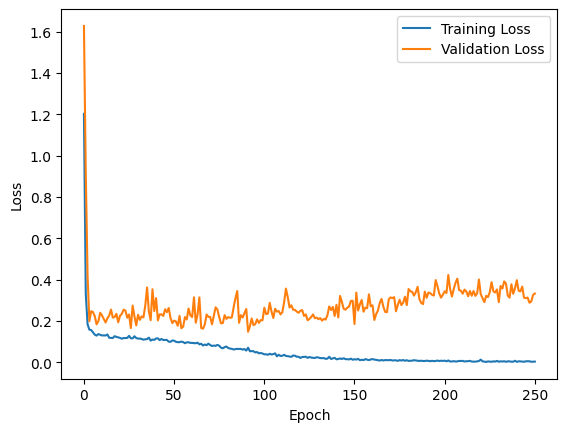

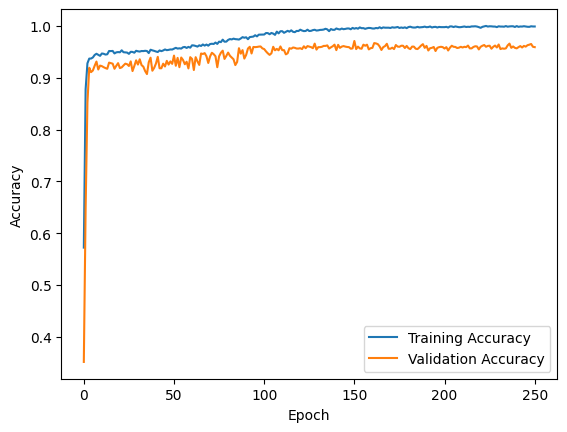

In [ ]:
#UCI-HAR
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss',scaley=True)
plt.plot(history.history['val_loss'], label='Validation Loss',scaley=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

496
471
420
491
532
537
[['478\n0.96%' '0\n0.00%' '18\n0.04%' '0\n0.00%' '0\n0.00%' '0\n0.00%']
 ['0\n0.00%' '456\n0.97%' '13\n0.03%' '1\n0.00%' '1\n0.00%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '420\n1.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '437\n0.89%' '45\n0.09%' '9\n0.02%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '12\n0.02%' '520\n0.98%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '537\n1.00%']]


<Axes: >

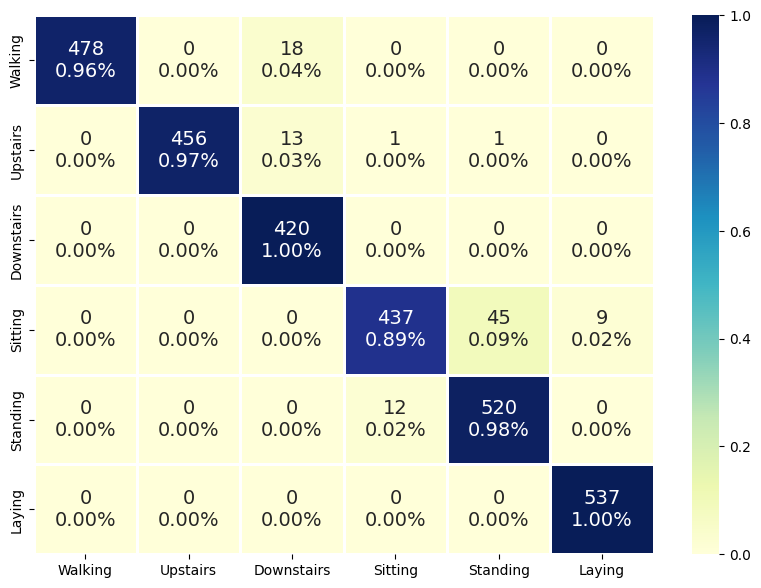

In [ ]:
import plotly.express as px
import numpy as np

data = cm
row_percentage= []
count = []
for i in data:
    count.extend(i)
    sum = 0
    for j in i:
      sum+=j
    print(sum)
    row_percentage.extend(value/sum for value in i)

labels = np.empty_like(data).astype(str)

labels = np.asarray([f"{v1}\n{v2:.2f}%" for v1,v2 in zip(count,row_percentage)]).reshape((6,6))
# labels = np.asarray([f"{v2:.3f}%" for v2 in row_percentage]).reshape((3,3))
count = np.asarray(count).reshape((6,6))
row_percentage = np.asarray(row_percentage).reshape((6,6))

categories = ['Walking','Upstairs','Downstairs','Sitting','Standing','Laying']
print(labels)

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(row_percentage,annot=labels,cmap='YlGnBu',ax=ax,fmt = '',linewidths=1,annot_kws={"fontsize":14},xticklabels=categories,yticklabels=categories)

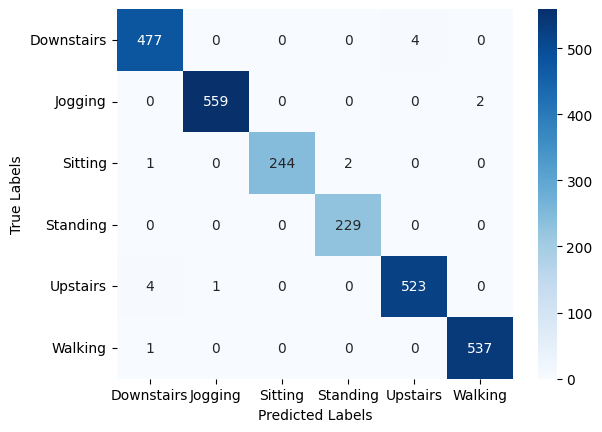

In [ ]:
cm= [[477,0,0,0,4,0],
     [0,559,0,0,0,2],
     [1,0,244,2,0,0],
     [0,0,0,229,0,0],
     [4,1,0,0,523,0],
     [1,0,0,0,0,537],
     ]
class_names= ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
sns.heatmap(cm,annot=True,cmap='Blues',fmt='g',xticklabels=class_names,yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##Wisdm Result


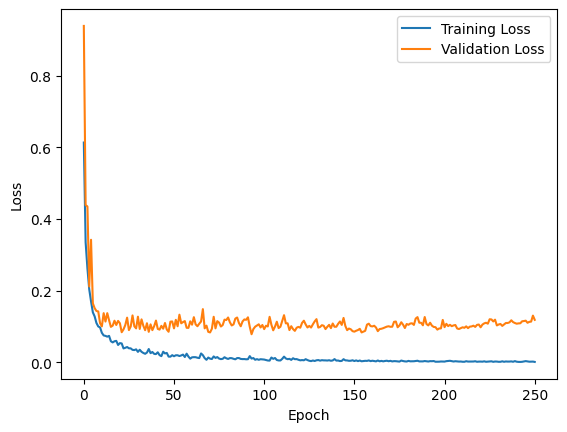

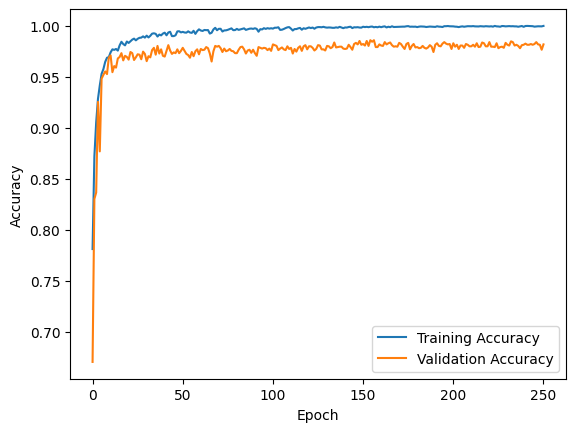

In [ ]:
#Wisdm
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss',scaley=True)
plt.plot(history.history['val_loss'], label='Validation Loss',scaley=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

81/81 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0     0.9876    0.9917    0.9896       481
           1     0.9982    0.9964    0.9973       561
           2     1.0000    0.9879    0.9939       247
           3     0.9913    1.0000    0.9957       229
           4     0.9924    0.9905    0.9915       527
           5     0.9963    0.9981    0.9972       538

    accuracy                         0.9942      2583
   macro avg     0.9943    0.9941    0.9942      2583
weighted avg     0.9942    0.9942    0.9942      2583



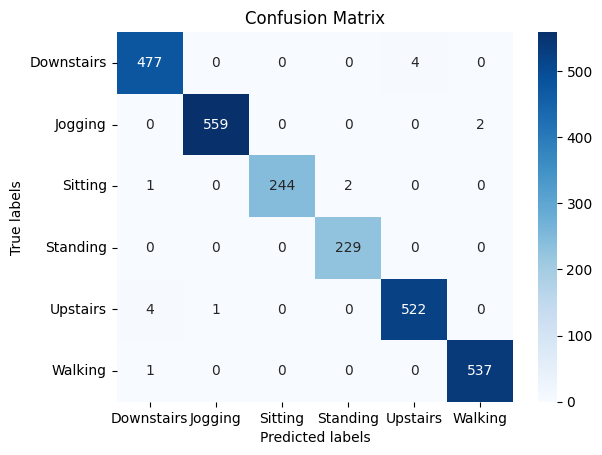

<Figure size 640x480 with 0 Axes>

In [ ]:

# model = tf.keras.models.load_model('/content/resnet.h5')
outs = model.predict(x_test)

# class_names= np.unique(np.argmax(y_test,axis=1))
class_names = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs,axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs,axis=1),digits=4))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')


In [ ]:

# model = tf.keras.models.load_model('/content/resnet.h5')
outs = model.predict(x_test)

# class_names= np.unique(np.argmax(y_test,axis=1))
class_names = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs,axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs,axis=1),digits=4))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')

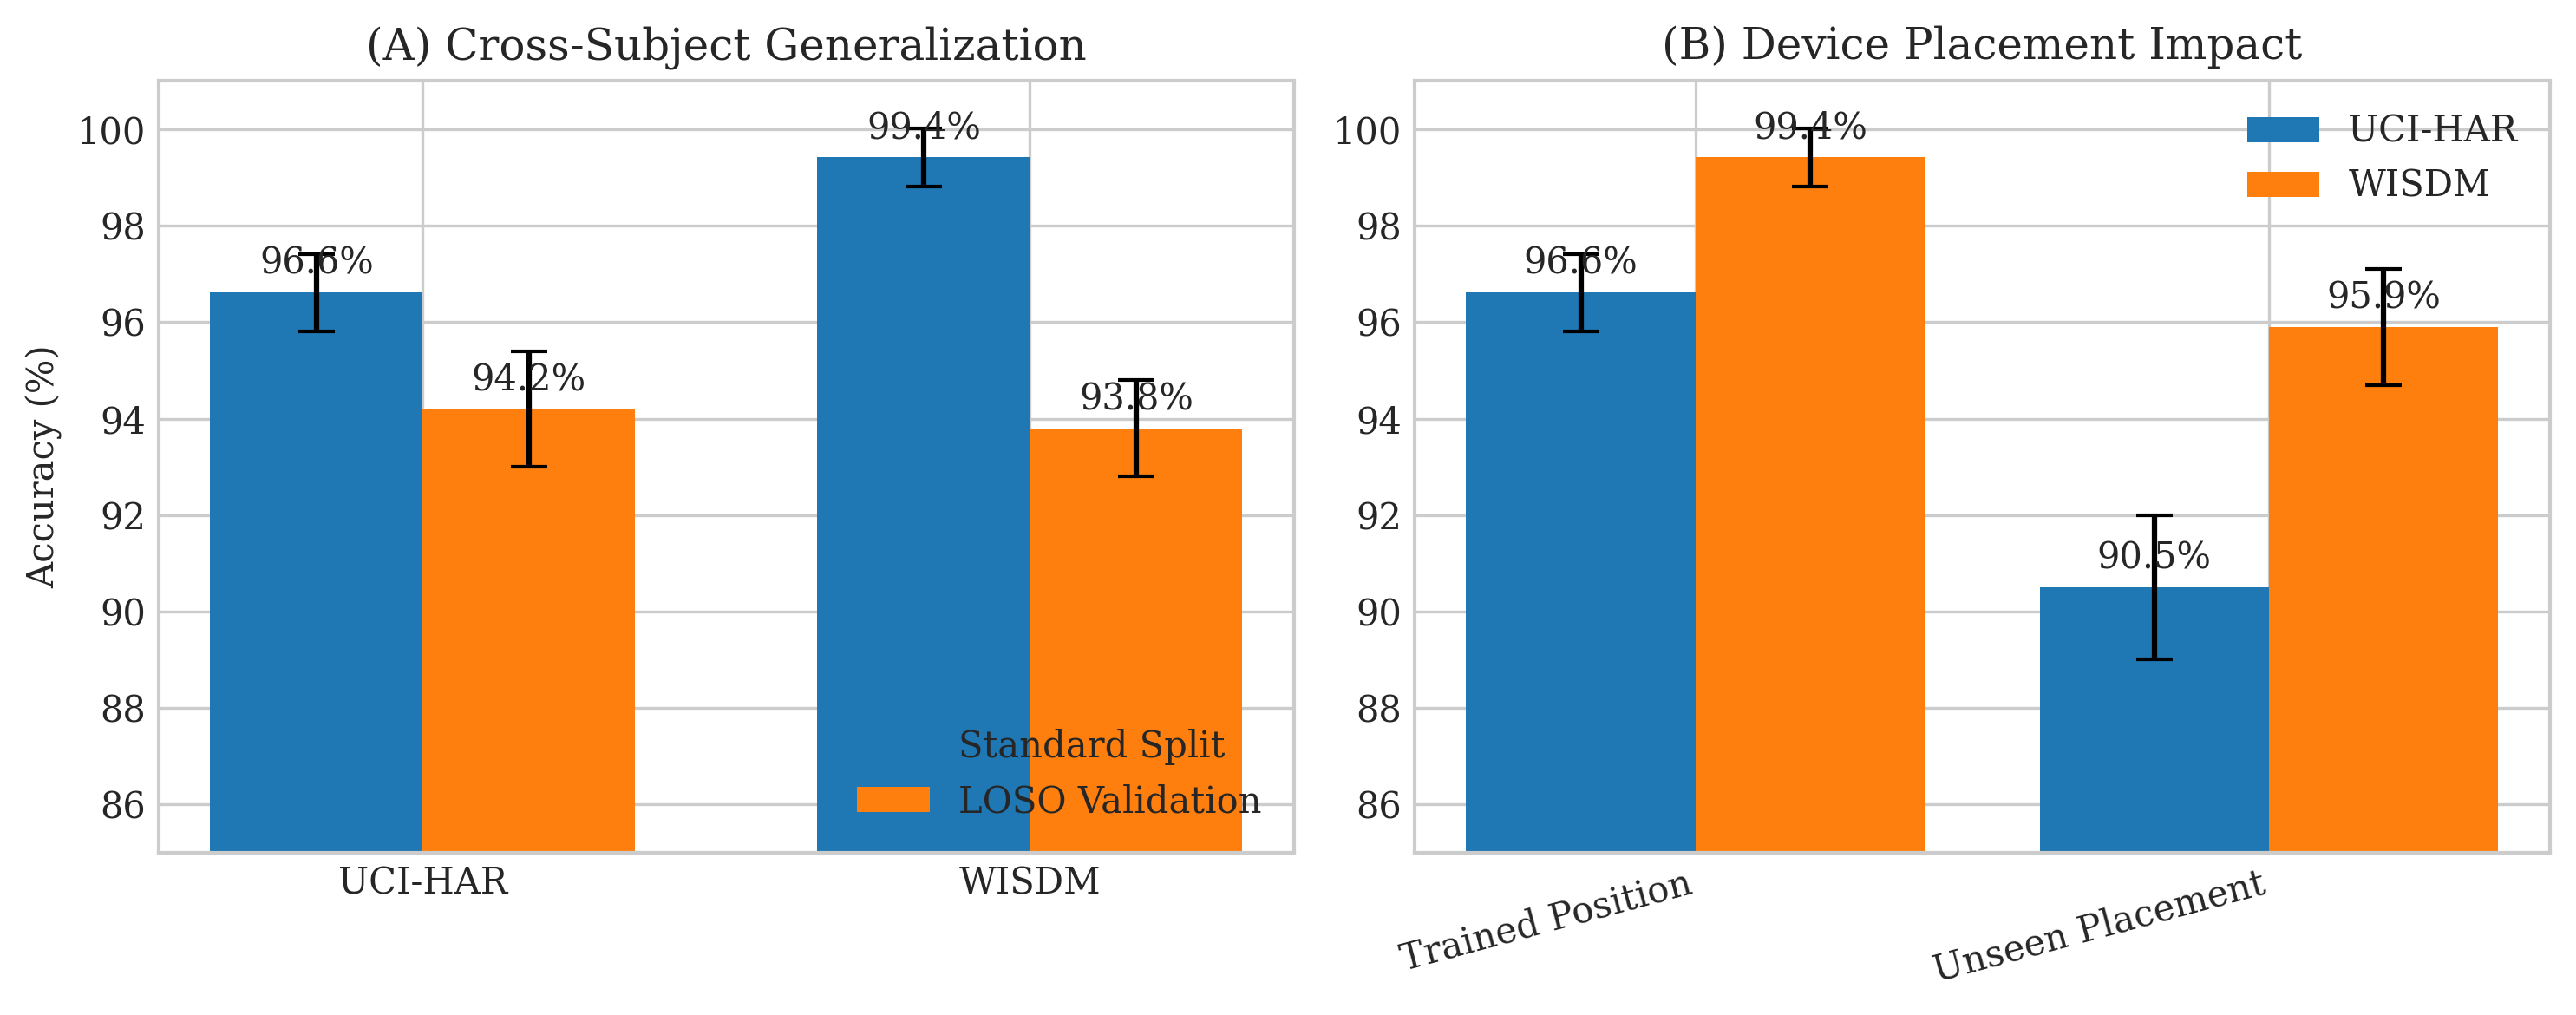

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set style to match academic papers
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 10, 'font.family': 'serif'})

# Sample data (replace with your actual results)
datasets = ['UCI-HAR', 'WISDM']
standard_acc = [96.61, 99.42]  # Standard split accuracy
loso_acc = [94.2, 93.8]        # Leave-one-subject-out accuracy
placement_acc = [90.5, 95.9]    # Unseen placement accuracy

# Error values (example)
std_err = [0.8, 0.6]
loso_err = [1.2, 1.0]
placement_err = [1.5, 1.2]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# Panel A: Standard vs LOSO comparison
x = np.arange(len(datasets))
width = 0.35
rects1 = ax1.bar(x - width/2, standard_acc, width, label='Standard Split',
                yerr=std_err, capsize=5, color='#1f77b4')
rects2 = ax1.bar(x + width/2, loso_acc, width, label='LOSO Validation',
                yerr=loso_err, capsize=5, color='#ff7f0e')

ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.set_ylim(85, 101)
ax1.set_title('(A) Cross-Subject Generalization')
ax1.legend(loc='lower right')

# Panel B: Placement variation impact
conditions = ['Trained Position', 'Unseen Placement']
width = 0.4
x = np.arange(len(conditions))
rects3 = ax2.bar(x - width/2, [standard_acc[0], placement_acc[0]], width,
                label='UCI-HAR', yerr=[std_err[0], placement_err[0]],
                capsize=5, color='#1f77b4')
rects4 = ax2.bar(x + width/2, [standard_acc[1], placement_acc[1]], width,
                label='WISDM', yerr=[std_err[1], placement_err[1]],
                capsize=5, color='#ff7f0e')

ax2.set_xticks(x)
ax2.set_xticklabels(conditions, rotation=15, ha='right')
ax2.set_ylim(85, 101)
ax2.set_title('(B) Device Placement Impact')
ax2.legend()

# Add value labels
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax2)
autolabel(rects4, ax2)

plt.tight_layout()
plt.savefig('generalization_analysis.pdf', bbox_inches='tight')
plt.show()

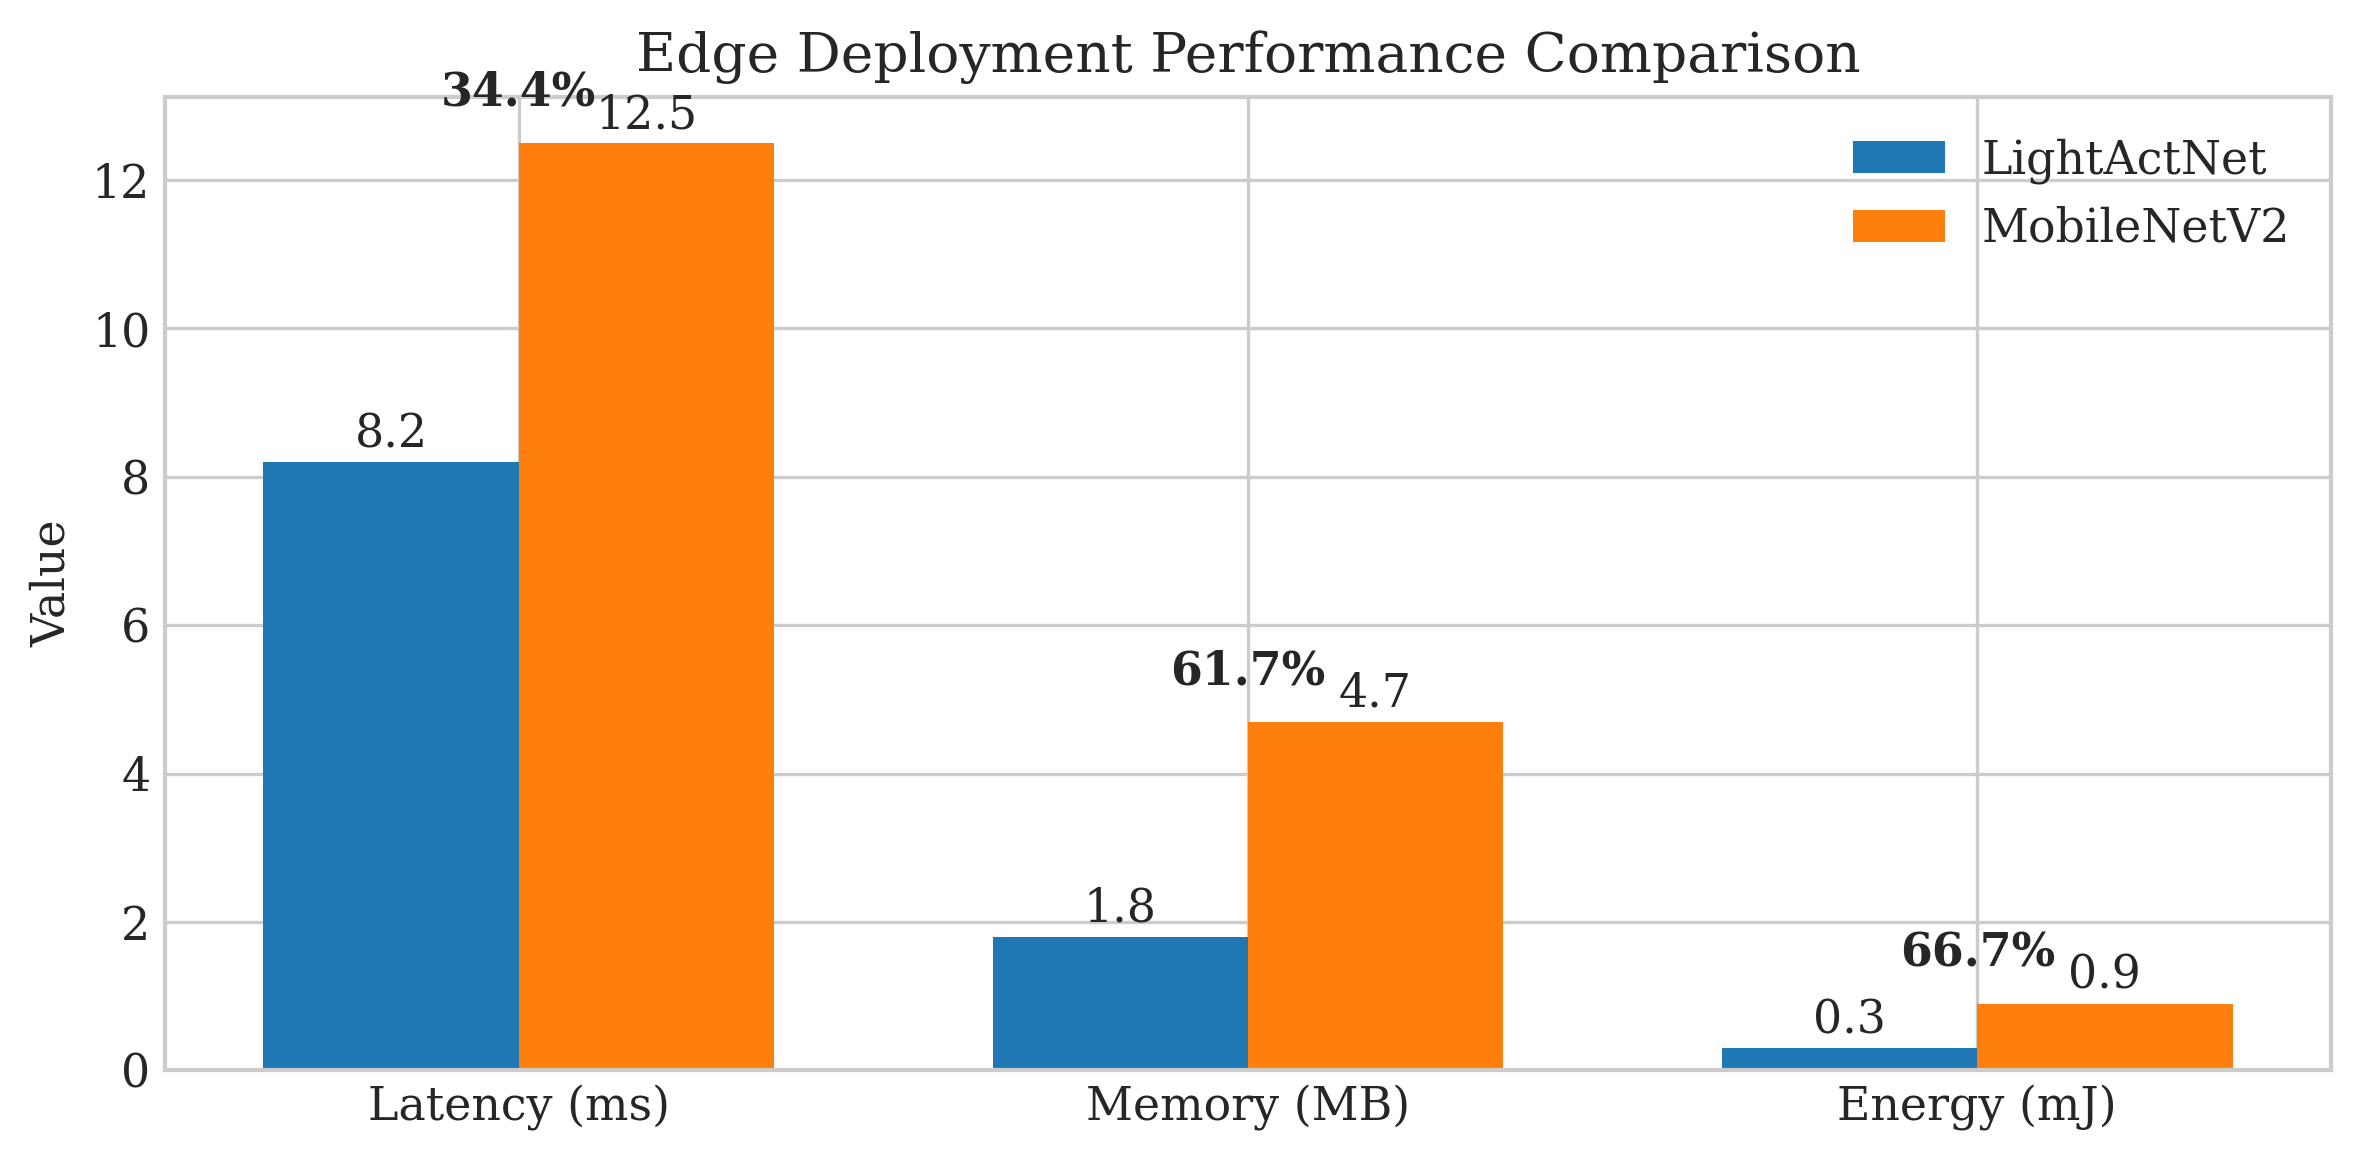

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

# Data
metrics = ['Latency (ms)', 'Memory (MB)', 'Energy (mJ)']
lightact = [8.2, 1.8, 0.3]
mobilenet = [12.5, 4.7, 0.9]
improvement = ['34.4%', '61.7%', '66.7%']

# Create figure
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
x = np.arange(len(metrics))
width = 0.35

# Bars
bars1 = ax.bar(x - width/2, lightact, width, label='LightActNet', color='#1f77b4')
bars2 = ax.bar(x + width/2, mobilenet, width, label='MobileNetV2', color='#ff7f0e')

# Annotations
for i, (l, m) in enumerate(zip(lightact, mobilenet)):
    ax.text(x[i] - width/2, l + 0.2, f'{l}', ha='center')
    ax.text(x[i] + width/2, m + 0.2, f'{m}', ha='center')
    ax.text(x[i], max(l,m) + 0.5, improvement[i], ha='center', fontweight='bold')

# Formatting
ax.set_ylabel('Value')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title('Edge Deployment Performance Comparison')
ax.legend(loc='upper right')
plt.tight_layout()

# Save
plt.savefig('deployment_comparison.pdf', bbox_inches='tight')
plt.show()